# Hamiltonian Time Evolution

In [1]:
import numpy as np
np.warnings.filterwarnings('ignore')

import pickle

from scipy.linalg import expm
from scipy.linalg import lstsq
from scipy.linalg import eigh

from pprint import pprint
from tqdm import tqdm

# Everything we need from Qiskit
from qiskit import ClassicalRegister, QuantumRegister, QuantumCircuit
from qiskit import execute, Aer
from qiskit.quantum_info import Pauli

from qiskit.aqua.operators import WeightedPauliOperator
from qiskit.aqua.components.initial_states import Custom

import qutip as qt

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
sns.set(rc={'figure.figsize':(16,8)})
sns.set()

import itertools

import sys
sys.path.append("../src/")
from hamiltonian import *
from utils import *
from qiskit_circuits import *
from qite import *

## Testing operator construction

In [2]:
def sigma_real_terms(n_qubits):
    """
    Get all possible pauli operators with an odd number of Y gates for n_qubit qubits 
    
    Input:
        n_qubits (int) : number of qubits 

    Returns:
        sigmas (list<WeightedPauliOperator>) : List of pauli operators with an odd number of Y

    """ 
    pauli_strings=["I","X","Y","Z"]
    pauli_product_strings=list(map(lambda x : "".join(x),list(itertools.product(*[pauli_strings for i in range(n_qubits)]))))

    ## Extract out pauli terms of odd number of Y 
    paulis=[]
    for string in pauli_product_strings:
#         if string.count("Y")%2==0:
        paulis.append(Pauli.from_label(string))

    sigmas=[]
    for pauli in paulis:
        sigma=[(1.0,pauli)]
        sigmas.append(WeightedPauliOperator(sigma))

    return sigmas

def beta_terms(H,sigmas):
    """
    Compute beta={H,sigma}

    Input:
        H (hamiltonian.EncodingHamiltonian) : Qubit Hamiltonian
        sigmas (list<WeightedPauliOperator>) : List of pauli operators with an odd number of Y
            
    Returns:

        b (dictionary) : b operator expressed as dictionary of {label:coef}, each label is a pauli string.
    """
    beta_pauli_terms=[]
    # H_paulis=H_weighted_paulis(H)
    H_paulis=H.weighted_pauli
    for sigma in sigmas:
        product=(H_paulis.__mul__(sigma)+sigma.__mul__(H_paulis))
        product.chop(1e-5)
        terms=get_pauli_terms(product)
        beta_pauli_terms.append(terms)
    return beta_pauli_terms

H = hamiltonian_matrix(Nmax=4,hw=7.0,J=1,interaction_filename="toy_hamiltonian") 
H_qubit = GrayCodeHamiltonian(H)

## Get list of sigmas (all pauli terms with odd number Y gates)
n_qubits=H_qubit.N_qubits
## vector of WeightedPauliOperators representing vector Sigma
sigmas=sigma_real_terms(n_qubits)

## Construct b
beta_pauli_terms=beta_terms(H_qubit,sigmas)
for bI in beta_pauli_terms:
    print(bI)
    
      
## Construct S
S_pauli_terms=S_terms(sigmas)

pauli_set=get_intersection_pauli_terms(H_qubit,beta_pauli_terms,S_pauli_terms)

commuting_sets=get_commuting_sets(sorted(pauli_set))
for p in commuting_sets:
    print(p, commuting_sets[p],p[::-1])
    


{'II': (15.531709445+0j), 'IZ': (-15.968290555+0j), 'ZI': (-3.7182905549999994+0j), 'ZZ': (3.2817094450000006+0j), 'IX': (-4.286607049870561+0j), 'ZX': (-4.286607049870561+0j), 'XI': (-7.826237921249264+0j), 'XZ': (7.826237921249264+0j)}
{'IX': (15.531709445+0j), 'ZX': (-3.7182905549999994+0j), 'II': (-4.286607049870561+0j), 'ZI': (-4.286607049870561+0j), 'XX': (-7.826237921249264+0j)}
{'IY': (15.531709445+0j), 'ZY': (-3.7182905549999994+0j), 'XY': (-7.826237921249264+0j)}
{'IZ': (15.531709445+0j), 'II': (-15.968290555+0j), 'ZZ': (-3.7182905549999994+0j), 'ZI': (3.2817094450000006+0j), 'XZ': (-7.826237921249264+0j), 'XI': (7.826237921249264+0j)}
{'XI': (15.531709445+0j), 'XZ': (-15.968290555+0j), 'XX': (-4.286607049870561+0j), 'II': (-7.826237921249264+0j), 'IZ': (7.826237921249264+0j)}
{'XX': (15.531709445+0j), 'YY': (-3.2817094450000006+0j), 'XI': (-4.286607049870561+0j), 'IX': (-7.826237921249264+0j)}
{'XY': (15.531709445+0j), 'YX': (3.2817094450000006+0j), 'YZ': (4.286607049870561+

In [117]:
def B_pauli_operator(delta_time,sigmas,S_pauli_terms,b_pauli_terms,expectation_values,B_threshold,verbose=False):
        
    
    n_qubits=sigmas[0].num_qubits

    ## compute b
    num_sigmas=len(sigmas)
    b=np.zeros(num_sigmas)
    for sigma_idx in range(num_sigmas):
        bI=b_pauli_terms[sigma_idx]
        for term in bI:
            b[sigma_idx]+=bI[term]*expectation_values[term]
          
    ## Comput S
    Smatrix=np.asmatrix(np.zeros((num_sigmas,num_sigmas)))
    for i in range(num_sigmas):
        for j in range(num_sigmas):
            Sij=S_pauli_terms[(i,j)]
            for term in Sij:
                #(S+S^T) gives rise to factor of 2
                Smatrix[i,j]+=2*Sij[term]*expectation_values[term] 

    ## Solve for a in (S+S^T)a=b
    a,_,_,_=lstsq(Smatrix,b,cond=B_threshold)
    if verbose==True:
        print("Smatrix")
        print(Smatrix)
        print("b\n",b)
        print("a\n",a)
    
    ## Construct A from a
    identity_string="I"*n_qubits

    ##Null initialize A with 0.0*Identity. 
    B=WeightedPauliOperator([(0.0,Pauli.from_label(identity_string))])

    for i in range((len(sigmas))):
        B+=delta_time*a[i]*sigmas[i]

    if verbose==True:       
        print("t=",t)
        print("-----------------------------------------")

        print("wavefunction\n",wavefunction)        
        print("\nB operator")
        print(B.print_details())
        
        B_pauli_terms=get_pauli_terms(B)
        Bmatrix=reduce(lambda x,y: x+y,[B_pauli_terms[term]*get_pauli_matrix(term) for term in B_pauli_terms])
        print(Bmatrix)
        print("-----------------------------------------")
    
    return B

def initialize_circuit(q,c,initial_state="zeros",no_classical=False):
    """
    Initialize circuit.  
    
    input:
        q (qiskit.circuit.quantumregister.QuantumRegister) : qubits
        initial_state(str or np.array) : initial state of circuit
            "zeros" (str,default) : starting state is qubit state with all qubits in zero state
            "uniform" (str) : Uniform superposition of all qubit states 
             array(np.array) : normalized array of len(2**n_qubits)
    returns
        circuit (qiskit.circuit.quantumcircuit.QuantumCircuit) : initialized quantum circuit
    """    
    if initial_state is None:
        initial_state="zeros"
        
    if isinstance(initial_state, str):
        if not (initial_state=="zeros" or initial_state=="uniform"):
            sys.exit(f"{initial_state} not currently valid option")
        if no_classical:
            circuit = QuantumCircuit(q)
        else:
            circuit = QuantumCircuit(q,c)

        if initial_state=="uniform":
            circuit.h(q)
    else:
        circuit = QuantumCircuit(q,c)
        circuit.initialize(initial_state,q)
    return circuit

def run_circuit_statevector_counts(n_qubits,A_set,time,initialization=None):
        ## Initalize circuit
#         print("qubits ", n_qubits)
        q = QuantumRegister(n_qubits)
        c = ClassicalRegister(n_qubits)
        
        circuit=initialize_circuit(q,c,initial_state=initialization,no_classical=True)
        
        ## If A_set not t, then evolve cirucit using previously computed A matrices stored in A_set
        if len(A_set)>0:
            circuit=append_evolution_circuit(q,A_set,time,circuit)

        ## Execute circuit
        backend=Aer.get_backend("statevector_simulator")
        job = execute(circuit,backend)
  
        return job.result().get_statevector(circuit),job.result().get_counts(circuit)        

    

    
def run_te_experiment(H,num_iterations,delta_time,backend,initialization,A_threshold=1e-10,cstep=None):
    """
    Run qite evolution to get energies of ground state 
    """

    n_qubits=H.N_qubits
#     print("num qubits",n_qubits)
    n_shots=10000 ## Set to allowed number of shots at IBMQ
 
    ## Get list of sigmas (all pauli terms with odd number Y gates)
    sigmas=sigma_real_terms(n_qubits)
    ## Construct b in terms of paulis 
    b_pauli_terms=b_terms(H,sigmas)
    ## Construct S in terms of paulis
    S_pauli_terms=S_terms(sigmas)

    ## Get composite set of pauli terms that need to be calculated for QITE 
    pauli_set=get_intersection_pauli_terms(H,b_pauli_terms,S_pauli_terms)

    ## Get commuting set 
    commuting_sets=get_commuting_sets(sorted(pauli_set))


    ## Get commuting set 
#     commuting_sets=H.pauli_partitions
    
    ## Zero initialize 
    A_set=[]
    results_dict={}
#     a=np.zeros(len(sigmas))
    Energies=np.zeros(num_iterations)
#     Ccoefs=np.zeros(num_iterations)
    ## for each time step, run circuit and compute A for the next time step
    for t in tqdm(range(num_iterations)):
#     for t in range(num_iterations):
    #     print("")
        expectation_values={}
        if backend=='statevector_simulator':
            psi,counts=run_circuit_statevector_counts(n_qubits,A_set,delta_time,initialization="uniform")
#             print("psi\n",psi)
            ## Run circuit to get state vector
#             print(len(A_set))
            
            if t>0:
                for state in counts:
                    if t==1:
                        results_dict[state[::-1]] = [counts[state]]
                    else:
                        results_dict[state[::-1]].append(counts[state])
                    

            ## Compute expectation value for each pauli term 
            for pauli_id in commuting_sets:        
                for pauli in commuting_sets[pauli_id]: 
                    pauli_mat = get_pauli_matrix(pauli)
                    e_value=np.conj(psi).T @ pauli_mat @ psi
                    expectation_values[pauli]=e_value
                    
                    
        else:
            for pauli_id in commuting_sets:   
                ## Run circuit to get counts 
                meas_results=run_circuit_qasm(n_qubits,A_set,pauli_id,n_shots=n_shots,initialization="uniform")

                ## Compute expectation value for each pauli term 
                for pauli in commuting_sets[pauli_id]: 
                    expectation_values[pauli]=compute_expectation_value(pauli,meas_results)    


        ## Compute energy
        H_pauli=H.pauli_coeffs
        for key in H_pauli:
            Energies[t]+=H_pauli[key]*expectation_values[key]

#         print(Energies[t])
        
        ## Compute A
#         B=B_pauli_operator(delta_time,sigmas,S_pauli_terms,b_pauli_terms,expectation_values,A_threshold)
#         print(B.print_details())
#         A_set.append(H.weighted_pauli)

        A_set.append(B_pauli_operator(delta_time,sigmas,S_pauli_terms,b_pauli_terms,expectation_values,A_threshold))
#         A_set.append(H.weighted_pauli)
#         if isinstance(cstep,int):
#             if t%cstep==0:
#                 identity_string="I"*n_qubits
#                 A_combine=WeightedPauliOperator([(0.0,Pauli.from_label(identity_string))])
#                 for A in A_set:
#                     A_combine+=A
#                 A_set=[A_combine]

    return Energies,results_dict

In [118]:
#####################################       
# Prepare and run the evolution circuit
#####################################       

# num_iterations=3
num_iterations=4
delta_time=0.01
verbose=False
backend = 'statevector_simulator'
initialization="uniform"

Energy_table=[]
H = hamiltonian_matrix(Nmax=4,hw=7.0,J=1,interaction_filename="toy_hamiltonian") 
H_qubit = GrayCodeHamiltonian(H)

backend = 'statevector_simulator'
sv_energies,results_dict=run_te_experiment(H_qubit,num_iterations,delta_time,backend,initialization,A_threshold=1e-10)

# for threshold in [1e-1,1e-2,1e-5,1e-10]:
#     backend = 'qasm_simulator'
#     Energies,_=run_qite_experiment(H_qubit,num_iterations,delta_time,backend,initialization,A_threshold=threshold)
#     Energy_table.append(Energies)


# print(results_dict)
print(sv_energies)
print(len(sv_energies))

100%|██████████| 4/4 [00:00<00:00, 32.26it/s]

[1.70943224 1.70237954 1.69534422 1.68832623]
4


In [119]:
print(H_qubit.weighted_pauli.print_details())

II	(7.7658547225+0j)
IZ	(-7.9841452775+0j)
ZI	(-1.8591452774999997+0j)
ZZ	(1.6408547225000003+0j)
IX	(-2.1433035249352805+0j)
ZX	(-2.1433035249352805+0j)
XI	(-3.913118960624632+0j)
XZ	(3.913118960624632+0j)



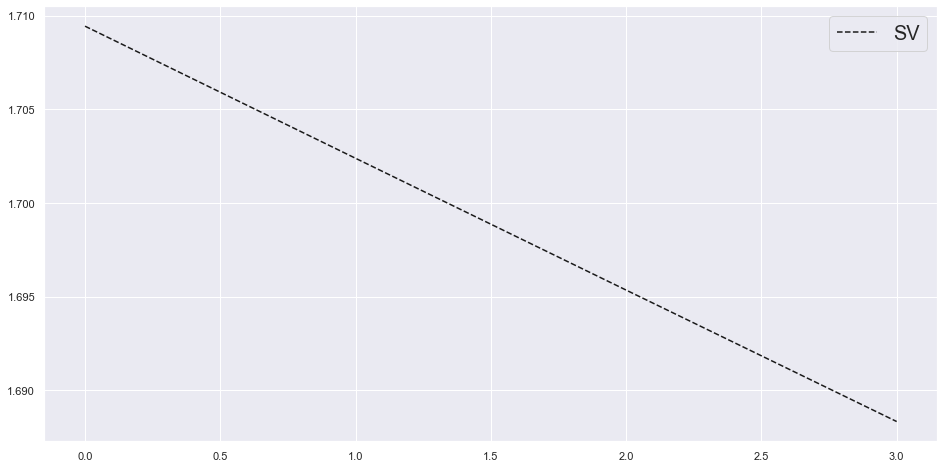

In [120]:
time=[t for t in range(num_iterations)]
plt.plot(sv_energies,'k--',label="SV")
# plt.plot(time,Energy_table[0],'c^',label="qasm 1e-1")
# plt.plot(time,Energy_table[1],'b^',label="qasm 1e-2")
# plt.plot(time,Energy_table[2],'g^',label="qasm 1e-5")
# plt.plot(time,Energy_table[3],'r^',label="qasm 1e-10")
plt.legend(prop={'size': 20})

In [84]:
H = hamiltonian_matrix(Nmax=4,hw=7.0,J=1,interaction_filename="toy_hamiltonian")
H_qubit = GrayCodeHamiltonian(H)
my_pauli = H_qubit.weighted_pauli
print(my_pauli.print_details())


# Range of Trotter steps to use
min_trotter_steps = 1
max_trotter_steps = 21
# Arbitrary simulation time




backend = Aer.get_backend('statevector_simulator')

states_gc = ['00', '10', '11', '01']
results_dict_gc = {x : np.zeros(max_trotter_steps) for x in states_gc}

trace_dists_gc = np.zeros(max_trotter_steps)

for n_trotter_steps in tqdm(range(min_trotter_steps, max_trotter_steps + 1)):
    # Prepare and run the evolution circuit
    q = QuantumRegister(H_qubit.N_qubits)
    circuit = QuantumCircuit(q)
    
    circuit.h(q)
    
    circuit += my_pauli.evolve(
        None, evo_time=delta_time*n_trotter_steps, num_time_slices=n_trotter_steps,
        quantum_registers=q,
        expansion_mode='trotter'
    )
    
      # Get and process results
    job = execute(circuit, backend)
    statevector = job.result().get_statevector(circuit)
    results = job.result().get_counts(circuit)
#     print(results)
#     if n_trotter_steps == max_trotter_steps:
#     print("state vector")
#     print(statevector)
        
#     trace_dists_gc[n_trotter_steps-1] = qt.tracedist(qt.Qobj(exact_wavefunction_gc), qt.Qobj(statevector))
    
    for state in results_dict_gc.keys():
        # Need to reverse the state we put the counts in because our labels are
        # normally ordered, and Qiskit gives them to us backwards
        results_dict_gc[state[::-1]][n_trotter_steps-1] = results[state]

 10%|▉         | 2/21 [00:00<00:01, 11.75it/s]

II	(7.7658547225+0j)
IZ	(-7.9841452775+0j)
ZI	(-1.8591452774999997+0j)
ZZ	(1.6408547225000003+0j)
IX	(-2.1433035249352805+0j)
ZX	(-2.1433035249352805+0j)
XI	(-3.913118960624632+0j)
XZ	(3.913118960624632+0j)



100%|██████████| 21/21 [00:00<00:00, 22.49it/s]


In [85]:
print(results_dict_gc)

{'00': array([0.24832636, 0.24773716, 0.24835942, 0.25038752, 0.25406663,
       0.25967075, 0.26747705, 0.27773833, 0.29065576, 0.30635375,
       0.32485906, 0.34608556, 0.3698261 , 0.39575202, 0.42342068,
       0.45229059, 0.48174328, 0.51111057, 0.53970554, 0.56685516,
       0.59193248]), '10': array([0.25167364, 0.25664588, 0.26460656, 0.27499929, 0.28705772,
       0.29985613, 0.31237054, 0.32354657, 0.3323692 , 0.33792988,
       0.3394865 , 0.33651211, 0.32872933, 0.31612817, 0.29896623,
       0.27775141, 0.25320859, 0.22623264, 0.19783114, 0.16906091,
       0.14096284]), '11': array([0.25      , 0.24561696, 0.23703402, 0.2246132 , 0.20887565,
       0.19047312, 0.17015241, 0.1487151 , 0.12697504, 0.10571637,
       0.08565444, 0.06740233, 0.05144457, 0.03811981, 0.0276131 ,
       0.01995801, 0.01504813, 0.01265679, 0.01246332, 0.01408393,
       0.01710468]), '01': array([0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25,
       0.25, 0.25, 0.25, 0.25, 0.25

In [86]:
print(results_dict)

{'00': [0.250321646164126, 0.250643248731373, 0.250964807292674, 0.251286321440205, 0.251607790767375, 0.25192921486883, 0.252250593340441, 0.25257192577931, 0.252893211783758, 0.253214450953327, 0.253535642888774, 0.253856787192068, 0.25417788346639, 0.254498931316122, 0.254819930346852, 0.255140880165363, 0.255461780379638, 0.255782630598848, 0.256103430433355, 0.256424179494704], '10': [0.25007853182981, 0.250156398199159, 0.250233600597769, 0.250310140516897, 0.250386019449302, 0.250461238889202, 0.250535800332249, 0.250609705275484, 0.250682955217306, 0.250755551657435, 0.250827496096878, 0.250898790037896, 0.250969434983965, 0.251039432439745, 0.251108783911048, 0.251177490904796, 0.251245554928998, 0.251312977492707, 0.251379760105994, 0.251445904279909], '01': [0.250085390672037, 0.250170457892781, 0.25025520218132, 0.250339624056851, 0.250423724038683, 0.250507502646218, 0.25059096039895, 0.250674097816454, 0.250756915418376, 0.250839413724429, 0.250921593254383, 0.25100345452

In [87]:
for state in results_dict:
    for i in range(len(results_dict[state])):
        if(abs(results_dict[state][i]-results_dict_gc[state][i])>1e-10):
#         if True:
            print(state,i,results_dict[state][i],results_dict_gc[state][i])

00 0 0.250321646164126 0.248326363453667
00 1 0.250643248731373 0.247737164208974
00 2 0.250964807292674 0.248359416589939
00 3 0.251286321440205 0.250387515611913
00 4 0.251607790767375 0.254066627949964
00 5 0.25192921486883 0.25967075146551
00 6 0.252250593340441 0.26747704721937
00 7 0.25257192577931 0.277738330859783
00 8 0.252893211783758 0.290655759413109
00 9 0.253214450953327 0.306353754078502
00 10 0.253535642888774 0.324859059076018
00 11 0.253856787192068 0.34608556058857
00 12 0.25417788346639 0.369826097590859
00 13 0.254498931316122 0.395752015294996
00 14 0.254819930346852 0.423420675762176
00 15 0.255140880165363 0.452290586541666
00 16 0.255461780379638 0.481743275879123
00 17 0.255782630598848 0.511110569496762
00 18 0.256103430433355 0.539705542504109
00 19 0.256424179494704 0.566855157527211
10 0 0.25007853182981 0.251673636546333
10 1 0.250156398199159 0.256645877152419
10 2 0.250233600597769 0.264606563998354
10 3 0.250310140516897 0.274999285431494
10 4 0.250386